# Analysis of Suicide Death Rates by Different Populations
                                By: Noah Eby

# Importance of the analysis of suicide death rates

Analyzing suicide death rate data that is broken down by age and race is important for several reasons:

Identifying Disparities and Patterns: Breaking down suicide data by age and race allows researchers, policymakers, and mental health professionals to identify disparities and patterns that might exist within different demographic groups. This information can highlight if certain age groups or racial/ethnic groups are more susceptible to suicide, helping focus intervention and prevention efforts where they are most needed.

Tailoring Prevention Strategies: Different age groups and racial/ethnic groups might have varying risk factors and reasons for suicide. Analyzing the data by these categories can help tailor prevention strategies to address the unique challenges faced by different populations. What works for one group may not be as effective for another, so targeted approaches are crucial.

Informing Policy Decisions: When policymakers have access to detailed suicide death rate data, they can make informed decisions about allocating resources and implementing policies aimed at reducing suicide rates. Policies can be more effective when they consider the specific needs and vulnerabilities of different age and racial groups.

Monitoring Trends: Analyzing data over time allows for the monitoring of trends and changes in suicide rates among different demographics. This information can help gauge the effectiveness of interventions, identify emerging issues, and guide ongoing efforts to prevent suicide.

Understanding Contributing Factors: Different age and racial groups may face unique challenges and experiences that contribute to their mental health and well-being. Analyzing suicide data broken down by these categories can provide insights into the contributing factors that may influence suicide rates, such as socioeconomic conditions, access to mental health services, cultural factors, and systemic inequalities.

Addressing Stigma and Cultural Norms: Cultural norms and stigma around mental health can vary among different racial and ethnic groups. By understanding how these factors interact with suicide rates, mental health professionals can develop culturally sensitive approaches to promote mental health awareness, reduce stigma, and encourage help-seeking behaviors.

Tailoring Outreach and Education: Prevention and awareness campaigns need to be relevant and relatable to different demographics. Analyzing data by age and race helps in tailoring educational materials, outreach efforts, and public awareness campaigns that resonate with specific groups and are more likely to be effective in raising awareness about suicide and available resources.

Resource Allocation: Limited resources for mental health support and suicide prevention require careful allocation. Analyzing data by age and race can help determine which groups are most in need of resources and support, ensuring that assistance reaches those who are at the highest risk.

In summary, analyzing suicide death rate data by age and race is crucial for understanding the complex factors contributing to suicide rates among different demographic groups. This information enables targeted interventions, more effective policies, and the development of culturally sensitive approaches to suicide prevention.

# Data Collection and Imputation

All the data was downloaded from the U.S. Department of Health & Human Services' website. Here is the link to the specific database used in this tutorial. https://catalog.data.gov/dataset/death-rates-for-suicide-by-sex-race-hispanic-origin-and-age-united-states-020c1 Keep in mind, this data was collected via various way, but are all traced to local hospitals, police data or other offical health reporting agencies.  Note, this data was collected from 1980-2018 only in the United States.


In [72]:
# data collection
import numpy as np
import pandas as pd
import re

# plotting graphs and the map of every country
import matplotlib.pyplot as plt
import plotly.express as px

# machine learning and filling in missing data
from sklearn import linear_model
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

# hypothesis testing
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

# to display images
from IPython.display import Image

pd.set_option('display.max_rows', None)

# Importing Data

The first step is to curate the data set to fit what kind of data we need for our analysis.  This requires imporint the data, renaming columns, and dropping data that is not nessasary. There will be data missing from the final data set, but that will be dealt with as that specific data is processed in the data analysis section.

In [39]:
# read in the life expectancy data
df = pd.read_csv("DeathRate.csv")

# remove the unwanted columns
df = df[["UNIT_NUM", "STUB_LABEL", "YEAR", "AGE", "ESTIMATE"]]

# rename the columns
df = df.rename(columns={"STUB_LABEL": "Demographic", \
                        "ESTIMATE" : "Suicide Death Rate", "YEAR" : "year", "AGE" : "Age"})

# remove the rows that are not needed (year < 1980)
df.drop(df[df.year < 1980 ].index, inplace=True)

#remove "UNIT_NUM" data what is 1, because the database specified that is age adjusted data. We will used the raw data
df.drop(df[df.UNIT_NUM == 1].index, inplace=True)


# Define a function to apply to each value in Demographic
def sex_transform_value(value):
    
    if "Male" in value:
        return "Male"
    elif "Female" in value:
        return "Female"
    else:
        return "All sexes"
    
# Define a function to apply to each value in Demographic
def race_transform_value(value):
    
    if "Black or African American" in value:
        return "Black or African American"
    elif "American Indian or Alaska Native" in value:
        return "American Indian or Alaska Native"
    elif "White" in value:
        return "White"
    elif "Asian or Pacific Islander" in value:
        return "Asian or Pacific Islander"
    else:
        return "All races"
    

# Apply the function to create a new column
df['Sex'] = df['Demographic'].apply(sex_transform_value)

df['Race'] = df['Demographic'].apply(race_transform_value)

# Define the substring you want to check for
substring_to_check = 'Hispanic'

# Specify the column in which to search for the substring
column_to_search = 'Demographic'

# Use boolean indexing to filter and keep only rows without the specified substring in the specified column
df = df[~df[column_to_search].str.contains(substring_to_check)]

# remove the unwanted columns
df = df[["year", "Age", "Sex", "Race","Suicide Death Rate" ]]

df.head()

,year,Age,Sex,Race,Suicide Death Rate
698,1980,All ages,All sexes,All races,11.9
728,1981,All ages,All sexes,All races,12.0
817,1982,All ages,All sexes,All races,12.2
818,1983,All ages,All sexes,All races,12.1
819,1984,All ages,All sexes,All races,12.4


# Data Visualization

In this section we will look at various interesting trends through the data and visualize this with graphs. Starting simple. Lets look at the Suicide Death Rate over time from 1980 - 2018

In [ ]:
# graphs the mean and stdev of the feature provided for both the original and imputed data
# parameters include the column name (attribute), the label to put on the y-axis, and the titles of the graphs
def graph_custom(attribute, ylabel, title_mean, title_stdev):

    # Llabels the x and y axes and sets the size of the plot
    plt.figure(figsize=(15, 6))

    # set the first subplot for mean
    plt.subplot(1, 2, 1)
    
    # compute mean for each year and plot it (original data)
    mean = df_raw.groupby('year', as_index=False)[attribute].mean()
    plt.title(title_mean)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(mean['year'], mean[attribute])
    
    # compute mean for each year and plot it (imputed data)
    mean = df.groupby('year', as_index=False)[attribute].mean()
    plt.title(title_mean)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(mean['year'], mean[attribute])
    
    # create the legend
    plt.legend(['Before Imputation', 'After Imputation'], loc='upper left')

    # set the second subplot for standard deviation
    plt.subplot(1, 2, 2)
    
    # compute standard deviation for each year and plot it (original data)
    stdev = df_raw.groupby('year', as_index=False)[attribute].std()
    plt.title(title_stdev)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(stdev['year'], stdev[attribute])
    
    # compute standard deviation for each year and plot it (imputed data)
    stdev = df.groupby('year', as_index=False)[attribute].std()
    plt.title(title_stdev)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(stdev['year'], stdev[attribute])
    
    # create the legend
    plt.legend(['Before Imputation', 'After Imputation'], loc='upper left')

    plt.show()

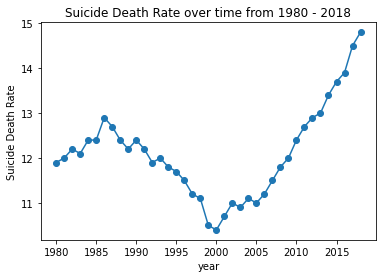

In [45]:
selected_data = df.iloc[0:39, [0,4]]

# Plot the selected rows as a line graph
plt.plot(selected_data['year'], selected_data['Suicide Death Rate'], marker='o')

# Add labels and title
plt.xlabel('year')
plt.ylabel('Suicide Death Rate')
plt.title('Suicide Death Rate over time from 1980 - 2018')

# Show the plot
plt.show()

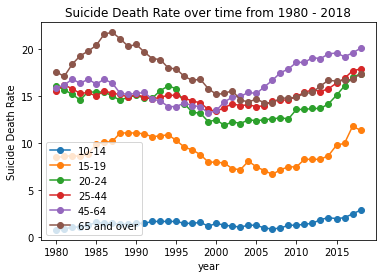

In [70]:
data_10_14 = df.iloc[39:78, [0,4]]
data_15_19 = df.iloc[117:156, [0,4]]
data_20_24 = df.iloc[156:195, [0,4]]
data_25_44 = df.iloc[195:234, [0,4]]
data_45_64 = df.iloc[312:351, [0,4]]
data_65_over = df.iloc[429:468, [0,4]]

# Plot the selected rows as a line graph
plt.plot(data_10_14['year'], data_10_14['Suicide Death Rate'], marker='o')
plt.plot(data_15_19['year'], data_15_19['Suicide Death Rate'], marker='o')
plt.plot(data_20_24['year'], data_20_24['Suicide Death Rate'], marker='o')
plt.plot(data_25_44['year'], data_25_44['Suicide Death Rate'], marker='o')
plt.plot(data_45_64['year'], data_45_64['Suicide Death Rate'], marker='o')
plt.plot(data_65_over['year'], data_65_over['Suicide Death Rate'], marker='o')

# Add labels and title
plt.xlabel('year')
plt.ylabel('Suicide Death Rate')
plt.title('Suicide Death Rate over time from 1980 - 2018')

plt.legend(['10-14', '15-19','20-24','25-44','45-64','65 and over'], loc='lower left')

# Show the plot
plt.show()

Here we see the different age groups across time and their suicide death rates. Notice how the 10-14 year olds have a Consistently lower value than the 15-19 which is lower than the 20-24. But this is only looking at the data visually and checking that. After all, the peak of the 15-19 is near the 20-24's lowest point, so could the difference be due to random varyability? The section below answers that question with a t-test to answer whether the 15-19 year olds have a statistically significant difference in Suicide death rate compared to 20-24 year olds on average. You can learn more about a t-test here. (https://www.ncbi.nlm.nih.gov/books/NBK553048/)

In [76]:
# Perform an independent t-test
t_statistic, p_value = ttest_ind(data_20_24['Suicide Death Rate'], data_15_19['Suicide Death Rate'])

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Check the p-value to determine statistical significance
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject null hypothesis: Means are significantly different.")
else:
    print("Fail to reject null hypothesis: Means are not significantly different.")

t-statistic: 15.565483805828336
p-value: 2.407458757704081e-25
Reject null hypothesis: Means are significantly different.


# Insight and Conclusion

Looking through the data and comparing based on race, sex,  and age from 1980 - 2018 has revealed various trends thorughout the data.  We can show what groups of people based on those catagories need the most attention to their mental health.  Additionally, we can see how the recent upswing in conversations about suicide prevention (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7005283/) correlates with the suicide death rates shown in the graph.  